In [1]:
from model import Network
from data import load_cifar10_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from metrics import lpips_gpu, psnr

In [2]:
# load to model
model_config = './model_config/fc2_cocktail_party_cifar10_instance.json'
checkpoint_path = './checkpoints/122123_fc2_cocktail_party_cifar10_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# reproducibility
random_seed = 2024

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)

# get val loader
batch_size = 16
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar10_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


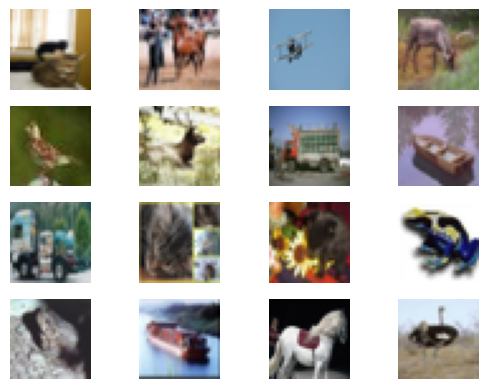

In [3]:
with torch.no_grad():
    fig, axes = plt.subplots(4, 4)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [4]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([256, 3072]), torch.Size([10, 256])]


In [5]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [6]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 7.292239691495796, 0.8808567737062569, 8.98613115383271)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 2088.473876953125
loss: 44.05485534667969
loss: 15.076604843139648
loss: 9.449360847473145
loss: 9.169038772583008
loss: 9.146869659423828
loss: 9.128600120544434
loss: 9.114157676696777
loss: 9.10923957824707
loss: 9.103715896606445
loss: 9.098952293395996
loss: 9.092263221740723
loss: 9.086424827575684
loss: 9.081195831298828
loss: 9.075159072875977
loss: 9.070164680480957
loss: 9.063858985900879
loss: 9.05873966217041
loss: 9.052861213684082
loss: 9.047504425048828
loss: 9.041749000549316
loss: 9.036567687988281
loss: 9.031286239624023
loss: 9.025437355041504
loss: 9.019709587097168
loss: 9.014307975769043


In [7]:
unmixing_matrix = unmixing_matrix.detach().to('cpu')
whitened_gradient = whitened_gradient.detach().to('cpu')

## PSNR Values

In [8]:
with torch.no_grad():
    psnr_match, psnr_is_positive, mean_psnr = psnr(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [9]:
psnr_match

[tensor([2, 6]),
 tensor([4, 1]),
 tensor([14,  9]),
 tensor([0, 7]),
 tensor([5, 3]),
 tensor([1, 8]),
 tensor([12, 15]),
 tensor([ 8, 13]),
 tensor([3, 5]),
 tensor([11,  0]),
 tensor([13, 12]),
 tensor([15,  2]),
 tensor([10, 14]),
 tensor([ 9, 10]),
 tensor([ 6, 11]),
 tensor([7, 4])]

In [10]:
mean_psnr

9.23533895611763

In [11]:
psnr_is_positive

[False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False]

## LPIPS

In [12]:
with torch.no_grad():
    lpips_match, lpips_is_positive, mean_lpips = lpips_gpu(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [13]:
lpips_match

[tensor([7, 4]),
 tensor([14,  3]),
 tensor([13,  2]),
 tensor([5, 7]),
 tensor([6, 8]),
 tensor([ 4, 10]),
 tensor([1, 5]),
 tensor([0, 6]),
 tensor([11,  9]),
 tensor([10,  0]),
 tensor([9, 1]),
 tensor([15, 13]),
 tensor([ 8, 11]),
 tensor([12, 15]),
 tensor([ 3, 14]),
 tensor([ 2, 12])]

In [14]:
mean_lpips

0.14164068852551281

In [15]:
lpips_is_positive

[True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False]

## Estimated images

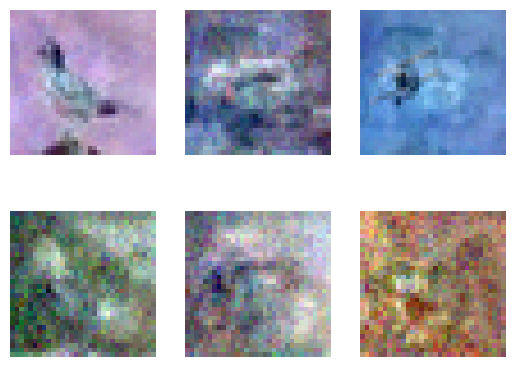

In [16]:
with torch.no_grad():
    estimated_img = (unmixing_matrix @ whitened_gradient)
    
    fig, axes = plt.subplots(2, 3)
    
    for estimate_idx, (match, ax) in enumerate(zip(lpips_match, axes.flatten())):
        estimate = estimated_img[match[0].item()]
        estimate_coeff = 1 if lpips_is_positive[match[0].item()] else -1
        img = colors.Normalize()(np.asarray(estimate_coeff * estimate).reshape(3, 32, 32).transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

## Original images

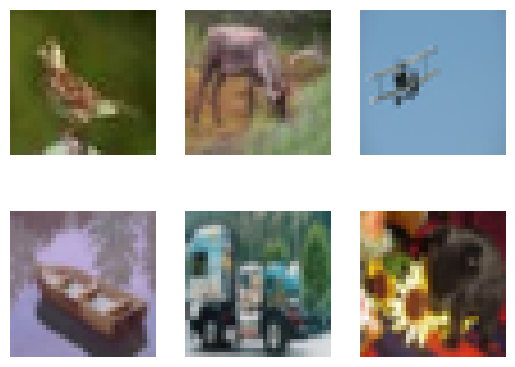

In [17]:
with torch.no_grad():
    fig, axes = plt.subplots(2, 3)
    
    for match, ax in zip(lpips_match, axes.flatten()):
        estimate = selected_val_batch_data[match[1].item()]
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()